# Correcting MNIST
### import

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Flatten, Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam
from PIL import Image
from tqdm import tqdm_notebook as tqdm
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


[]

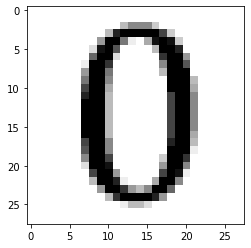

In [2]:
text_images = []
for i in range(10):
    text_images.append(np.array(Image.open('text image/'+str(i)+'.png').convert('L')).reshape(28, 28))
plt.imshow(text_images[0])
plt.gray()
plt.plot()

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train_f = x_train.reshape(60000, 784)
x_test_f = x_test.reshape(10000, 784)
num_classes = 10
y_train_k = np_utils.to_categorical(y_train, num_classes)
y_test_k = np_utils.to_categorical(y_test, num_classes)

y_train_img = np.zeros((len(y_train), 784))
y_test_img = np.zeros((len(y_test), 784))
for i in tqdm(range(10)):
    indexes = np.where(y_train == i)
    y_train_img[indexes] = text_images[i].reshape(784)
    indexes = np.where(y_test == i)
    y_test_img[indexes] = text_images[i].reshape(784)
    
y_train_img = y_train_img.astype('float32')
y_test_img = y_test_img.astype('float32')
y_train_img /= 255
y_test_img /= 255
y_train_img = 1 - y_train_img
y_test_img = 1 - y_test_img

[5 0 4 ... 5 6 8]
8


[]

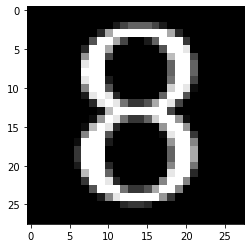

In [4]:
print(y_train)
print(y_train[60000-1])
plt.imshow(y_train_img[60000-1].reshape(28, 28))
plt.plot()

## Use Conv

In [5]:
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

modelConv = Sequential()
modelConv.add(Conv2D(16, (3, 3), 
                input_shape=(28, 28, 1), activation='relu'))
modelConv.add(Conv2D(32, (3, 3), activation='relu'))
modelConv.add(MaxPooling2D(pool_size=(2, 2)))
modelConv.add(Conv2D(64, (3, 3), activation='relu'))
modelConv.add(MaxPooling2D(pool_size=(2, 2)))
modelConv.add(Dropout(0.25))
modelConv.add(Flatten())
modelConv.add(Dense(128, activation='relu'))
modelConv.add(Dropout(0.25))
modelConv.add(Dense(784, activation='sigmoid'))
modelConv.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])


In [15]:
#modelConv.fit(x_train, y_train_img, epochs=100, batch_size=1000,
#         verbose=1, validation_data=(x_test, y_test_img))
#modelConv.save_weights('conv.hdf5')
score = modelConv.evaluate(x_test, y_test_img, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11381769843101501
Test accuracy: 0.801337480545044


## Simple

In [7]:
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

modelSimp = Sequential()
modelSimp.add(Dense(128, input_dim=784, activation='relu'))
modelSimp.add(Dense(64, activation='relu'))
modelSimp.add(Dense(32, activation='relu'))
modelSimp.add(Dense(64, activation='relu'))
modelSimp.add(Dense(128, activation='relu'))
modelSimp.add(Dense(784, activation='sigmoid'))
modelSimp.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [18]:
#modelSimp.fit(x_train_f, y_train_img, epochs=100, batch_size=1000,
#         verbose=1, validation_data=(x_test_f, y_test_img))
#modelSimp.save_weights('simp.hdf5')
score = modelSimp.evaluate(x_test_f, y_test_img, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11942405631542206
Test accuracy: 0.8007781505584717


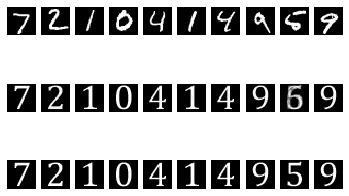

In [19]:
useConv = True
modelConv.load_weights('conv.hdf5')
modelSimp.load_weights('simp.hdf5')
if useConv:
    image_pred = modelConv.predict_proba(x_test[:10], verbose=0)
else:
    image_pred = modelSimp.predict_proba(x_test_f[:10], verbose=0)
#plt.imshow(x_test[0].reshape(28, 28))
#plt.imshow(image_pred[1].reshape(28, 28))
#plt.imshow(y_test_img[1].reshape(28, 28))
#plt.show()

fig, axes = plt.subplots(3, 10)
for i, pred_img in enumerate(image_pred):
    # 元画像を上段に表示する
    img = x_test[i].reshape(28, 28)
    axes[0][i].imshow(img)
    axes[0][i].axis('off')
    #axes[0][i].set_title(label, color='red')
    # AutoEncoder で次元圧縮した画像を下段に表示する
    axes[1][i].imshow(pred_img.reshape(28, 28))
    axes[1][i].axis('off')
    #AutoEncoder で復元した画像を下段に表示する
    input_img = y_test_img[i].reshape(28, 28)
    axes[2][i].imshow(input_img)
    axes[2][i].axis('off')

plt.show()

### Send to Processing
#### 先にGridDataCreatorを起動してください。

In [ ]:
useConv = True #True is use convolution, False is use simple
modelConv.load_weights('conv.hdf5')# Generated by convolution network
modelSimp.load_weights('simp.hdf5')# Generated by only dense network

from socket import socket, AF_INET, SOCK_DGRAM

HOST = "localhost"  
PORT = 4000

# ソケットを用意
s = socket(AF_INET, SOCK_DGRAM)
s.settimeout(1)
# バインドしておく
s.bind((HOST, PORT))
last_pred = None

while True:
    # 受信
    msg, address = s.recvfrom(81920)
    msg = msg.decode()
    if str(msg) == 'exit':
        print("recieveExit")
        break
    else:
        #print(f"message: {str(msg)}\nfrom: {address}")
        #print("recieve"+str(len(str(msg))))
        msg = str(msg).split('\n')
        recvCSV = []
        for i in msg:
            recvCSV.append(i.split(' '))
        if useConv:
            pred_img = modelConv.predict_proba(np.array(recvCSV).reshape(1, 28, 28, 1)).reshape(28, 28)
        else:
            pred_img = modelSimp.predict_proba(np.array(recvCSV).reshape(1, 784)).reshape(28, 28)
        last_pred = pred_img
        #print("predict")
        msg = ""
        for y in range(28):
            for x in range(28):
                msg += str(pred_img[x, y]) + " "
            msg = msg[:-1]
            msg += "\n"
        msg = msg[:-1]
        #print("send")
        s.sendto(msg.encode(), (HOST, 4001))
        #print("sent"+str(len(msg)))

# ソケットを閉じておく
s.close()

In [ ]:
plt.imshow(last_pred.reshape(28, 28))

plt.show()

## Categorize and Generate
### Categorize

In [ ]:
modelC = Sequential()
modelC.add(Conv2D(16, (3, 3), 
                input_shape=(28, 28, 1), activation='relu'))
modelC.add(Conv2D(32, (3, 3), activation='relu'))
modelC.add(MaxPooling2D(pool_size=(2, 2)))
modelC.add(Conv2D(64, (3, 3), activation='relu'))
modelC.add(MaxPooling2D(pool_size=(2, 2)))
modelC.add(Dropout(0.25))
modelC.add(Flatten())
modelC.add(Dense(128, activation='softmax'))
modelC.add(Dropout(0.25))
modelC.add(Dense(num_classes, activation='softmax'))

modelC.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])

#model.fit(x_train, y_train_k, batch_size=1000, epochs=20,
#                  verbose=1, validation_data=(x_test, y_test_k))
#model.save_weights('categorizer.hdf5')

### Generate

In [ ]:
modelG = Sequential()
modelG.add(Dense(32, input_dim=10, activation='relu'))
modelG.add(Dense(64, activation='relu'))
modelG.add(Dense(128, activation='relu'))
modelG.add(Dense(784, activation='sigmoid'))
modelG.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

#model.fit(y_train_k, y_train_img, epochs=10, batch_size=1000,
#         verbose=1, validation_data=(y_test_k, y_test_img))
#model.save_weights('generator.hdf5')

In [ ]:
modelC.load_weights('categorizer.hdf5')
modelG.load_weights('generator.hdf5')
cate_pred = modelC.predict_classes(x_test[:10], verbose=0)
#cate_pred = modelC.predict_proba(x_test[:10], verbose=0)
#cate_pred = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cate_pred = np_utils.to_categorical(cate_pred, 10)
image_pred = modelG.predict_proba(cate_pred, verbose=0)

#plt.imshow(x_test[0].reshape(28, 28))
#plt.imshow(image_pred[1].reshape(28, 28))
#plt.imshow(y_test_img[1].reshape(28, 28))
#plt.show()

fig, axes = plt.subplots(3, 10)
for i, pred_img in enumerate(image_pred):
    # 元画像を上段に表示する
    img = x_test[i].reshape(28, 28)
    axes[0][i].imshow(img)
    axes[0][i].axis('off')
    #axes[0][i].set_title(label, color='red')
    # AutoEncoder で次元圧縮した画像を下段に表示する
    axes[1][i].imshow(pred_img.reshape(28, 28))
    axes[1][i].axis('off')
    #AutoEncoder で復元した画像を下段に表示する
    input_img = y_test_img[i].reshape(28, 28)
    axes[2][i].imshow(input_img)
    axes[2][i].axis('off')

plt.show()

In [ ]:
selectClass = False
from socket import socket, AF_INET, SOCK_DGRAM

HOST = "localhost"  
PORT = 4000

# ソケットを用意
s = socket(AF_INET, SOCK_DGRAM)
s.settimeout(1)
# バインドしておく
s.bind((HOST, PORT))
last_pred = None

while True:
    # 受信
    msg, address = s.recvfrom(81920)
    msg = msg.decode()
    if str(msg) == 'exit':
        print("recieveExit")
        break
    else:
        #print(f"message: {str(msg)}\nfrom: {address}")
        #print("recieve"+str(len(str(msg))))
        msg = str(msg).split('\n')
        recvCSV = []
        for i in msg:
            recvCSV.append(i.split(' '))
        if selectClass:
            pred_cate = modelC.predict_classes(np.array(recvCSV).reshape(1, 28, 28, 1))
            pred_cate = np_utils.to_categorical(pred_cate, 10)
        else:
            pred_cate = modelC.predict_proba(np.array(recvCSV).reshape(1, 28, 28, 1))
        pred_img = modelG.predict_proba(pred_cate).reshape(28, 28)
        last_pred = pred_img
        #print("predict")
        msg = ""
        for y in range(28):
            for x in range(28):
                msg += str(pred_img[x, y]) + " "
            msg = msg[:-1]
            msg += "\n"
        msg = msg[:-1]
        #print("send")
        s.sendto(msg.encode(), (HOST, 4001))
        #print("sent"+str(len(msg)))

# ソケットを閉じておく
s.close()